In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F 

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path): 
    return glob.glob(path)   # returns all the files located in that path   


all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print('Ślusàrski')
print(unicodeToAscii('Ślusàrski'))    # will convert this to Slusarski

category_lines = {}  # dictionary containing the language as the key and the names under that language.
all_categories = []  # list containing all the languages 

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')  
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]  # stores the name of the file which actually represents the language
    all_categories.append(category)
    lines = readLines(filename)   # reads the names inside the files 
    category_lines[category] = lines  # adds it to the dictionary

n_categories = len(all_categories)  
print(category_lines['Italian'][:5])
print(n_categories)
print(n_letters)

Ślusàrski
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
18
57


In [3]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [4]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]
# function to return random name from the dataset
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, ' name =', line)

category = Spanish / line = Bautista
category = Spanish / line = Delgado
category = Chinese / line = Yue
category = French / line = Salvage
category = French / line = Beringer
category = Arabic / line = Morcos
category = Arabic / line = Atiyeh
category = Irish / line = Tadhg
category = French / line = Guillory
category = Korean / line = Yeo


In [5]:
category, line, category_tensor, line_tensor = randomTrainingExample()
print(category)
print(line)
print(category_tensor.shape)
print(line_tensor.shape)

English
Kurian
torch.Size([1])
torch.Size([6, 1, 57])


### RNN FROM SCRATCH

In [6]:
class RNN_fc(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN_fc, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.i2h = nn.Linear(input_size  +  hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)    

### Using torch.nn.rnn 

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = 1)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, h = self.rnn(x)
        out = out[-1,:,:]
        out = self.fc(out)
        return F.log_softmax(out,dim =1)
    

### LSTM

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, (h_n,c_n) = self.lstm(x)
        out = out[-1,:,:]
        out = self.fc(out)
        return F.log_softmax(out,dim =1)


### GRU

In [9]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = 1)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, h_n = self.gru(x)
        out = out[-1,:,:]
        out = self.fc(out)
        return F.log_softmax(out,dim =1)

In [10]:
def train(model, category_tensor, line_tensor):
    
    if model == rnn_fc:
        hidden = rnn_fc.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn_fc(line_tensor[i], hidden)
    else:    
        output = model(line_tensor)
        output = output.view(1,18)
    
    optimizer.zero_grad()
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

In [11]:
def categoryFromOutput(output):
    pred = torch.argmax(output,1)
    category_i = pred.item()
    return all_categories[category_i], category_i

In [12]:
n_hidden = 128
rnn_fc = RNN_fc(n_letters, n_hidden, n_categories)
model = RNN(n_letters, n_hidden, n_categories)
#model = LSTM(n_letters, n_hidden, n_categories)
#model = GRU(n_letters, n_hidden, n_categories)
learning_rate = 1e-4
criterion = nn.NLLLoss()
#optimizer = torch.optim.Adam(rnn_fc.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [13]:
current_loss = 0
all_losses = []
n_iters = 100000
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(model, category_tensor, line_tensor)
    current_loss += loss

    
    if iter % 1000 == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'correct' if guess == category else 'wrong ({})'.format(category)
        print("{:.0f}%\tloss: {:.4f}\tname: {}\t \tguess:{}\t \t{}".format(iter / n_iters * 100, loss, line, guess, correct))
    if iter % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0    

1%	loss: 2.8454	name: Cernochova	 	guess:Portuguese	 	wrong (Czech)
2%	loss: 2.6439	name: Chweh	 	guess:Vietnamese	 	wrong (Korean)
3%	loss: 2.6879	name: Sepulveda	 	guess:Russian	 	wrong (Spanish)
4%	loss: 2.7974	name: Devin	 	guess:Arabic	 	wrong (Irish)
5%	loss: 1.8241	name: Wawrzaszek	 	guess:Polish	 	correct
6%	loss: 2.1241	name: Jeon	 	guess:Chinese	 	wrong (Korean)
7%	loss: 2.7803	name: Caron	 	guess:Arabic	 	wrong (French)
8%	loss: 2.5725	name: Petit	 	guess:Dutch	 	wrong (Spanish)
9%	loss: 2.5266	name: Paskell	 	guess:Polish	 	wrong (English)
10%	loss: 2.6261	name: Sinagra	 	guess:Japanese	 	wrong (Italian)
11%	loss: 2.2874	name: Babineaux	 	guess:French	 	correct
12%	loss: 2.2691	name: Takecare	 	guess:Japanese	 	correct
13%	loss: 1.0133	name: Xie	 	guess:Korean	 	wrong (Chinese)
14%	loss: 1.3499	name: Tse	 	guess:Chinese	 	correct
15%	loss: 0.8615	name: Sokolsky	 	guess:Polish	 	correct
16%	loss: 1.8649	name: Ruan	 	guess:Arabic	 	wrong (Chinese)
17%	loss: 2.6823	name: Whyte

plotting the losses over epochs

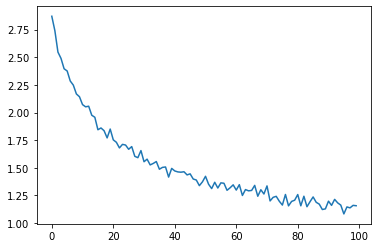

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

checking the performance by entering a random name from the dataset

In [15]:
test = lineToTensor('Abukara')
output = model(test)
print(categoryFromOutput(output))

('Japanese', 10)
